In [19]:
import numpy as np
import matplotlib.pylab as plt
from scipy.fft import ifft2
from scipy.ndimage import gaussian_filter
from scipy.fft import fftshift

import skimage
from scipy.interpolate import interp2d
from scipy.ndimage import gaussian_filter

# Phase Difference Matrix

Balci, Murat, et Hassan Foroosh. « Subpixel Registration Directly from the Phase Difference ». EURASIP Journal on Advances in Signal Processing 2006, nᵒ 1 (décembre 2006). https://doi.org/10.1155/ASP/2006/60796.


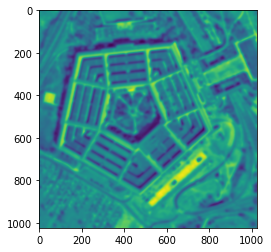

In [23]:
# ================
#  Generate data
# ================

# Pentagon aerial photo
# http://sipi.usc.edu/database/database.php?volume=aerials&image=37#top
image = skimage.data.camera()
image = skimage.io.imread('pentagon_1024.tiff')
image = skimage.exposure.rescale_intensity(image)
image = gaussian_filter(image, sigma=5)
plt.imshow(image);

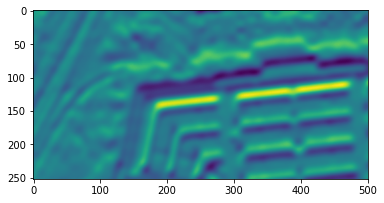

In [164]:
# Interpolation
x_span, y_span = np.arange(image.shape[0]), np.arange(image.shape[1])
x_grid, y_grid = np.meshgrid(x_span, y_span)

f = interp2d(x_span, y_span, image, kind='cubic')

x_A = np.arange(20, 521)
y_A = np.arange(80, 332) 

dx, dy = (0.7512, 10.101512)
A = f(x_A, y_A)
B = f(x_A + dx, y_A + dy)  #+ 0.81*np.random.randn(*np.shape(A))

plt.imshow(A - B);

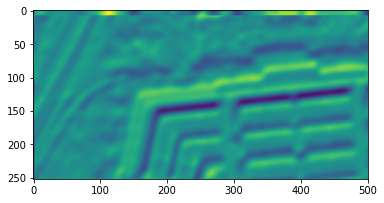

In [305]:
# FFT shift interpolation
a = np.fft.fft2(A)

kx = np.fft.fftfreq(A.shape[0])
ky = np.fft.fftfreq(A.shape[1])

k_xy = np.meshgrid(kx, ky, indexing='ij')

dx, dy = 50.2, 14.123
b2 = a*np.exp(-1j*(dx*k_xy[0] + dy*k_xy[1]))

B = np.abs( np.fft.ifft2(b2) ) + 0.1*np.random.randn(*A.shape)

plt.imshow(A - B);

In [307]:
from scipy.signal.windows import blackman

u = blackman(A.shape[0])[:, np.newaxis]
v = blackman(A.shape[1])[np.newaxis, :]
window = np.matmul(u, v)

plt.imshow(window); plt.title('blackman window');

In [308]:
# ====================
#  Fourier Transform
# ====================
a = np.fft.fft2(A*window)
b = np.fft.fft2(B*window)

#a = np.fft.fft2(A)
#b = np.fft.fft2(B)

ab = a * b.conj()
ab = np.fft.fftshift( ab )

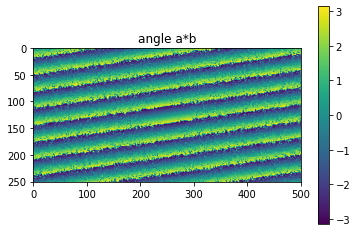

In [309]:
plt.imshow(np.angle(ab));
plt.title('angle a*b'); plt.colorbar();

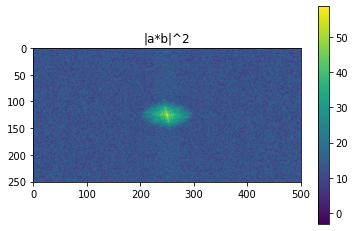

In [310]:
plt.imshow(np.log(np.abs(ab)**2));
plt.title('|a*b|^2'); plt.colorbar();

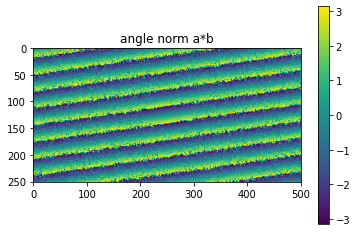

In [311]:
ab_normed = (ab)/np.abs(ab)
plt.imshow(np.angle(ab_normed));
plt.title('angle norm a*b'); plt.colorbar();

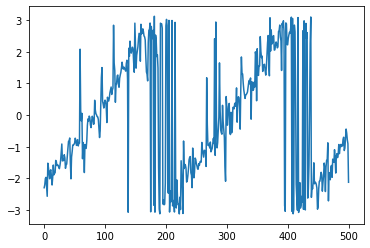

In [312]:
plt.plot(np.angle(ab)[150, :])

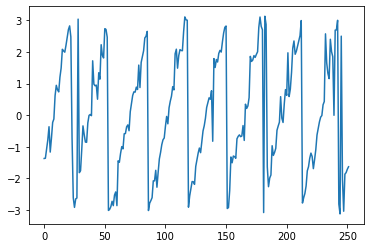

In [313]:
plt.plot(np.angle(ab)[:, 200])

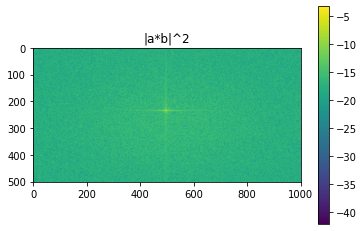

In [314]:
AB = np.fft.ifft2(ab/np.abs(ab), s=np.array(ab.shape)*2)
AB = np.fft.ifftshift(AB)
plt.imshow(np.log(np.abs(AB)**2));
plt.title('|a*b|^2'); plt.colorbar();

In [315]:
np.unravel_index(np.argmax(np.abs(AB), axis=None), AB.shape)

(236, 497)

In [304]:
A.shape

(252, 501)